In [2]:
# In this notebook, we use antevents to read in some previously
# captured lux (light level) sensor data. We use a sliding window
# transducer to smooth the data and then convert both the raw data and
# the smoothed data to Pandas "Series" data values. These can then be
# plotted directly in jupyter.

# Some initial setup
import pandas as pd
# needed to get the graphs to show up
%matplotlib inline
import matplotlib.style
# To workaround a bug in pandas, see
# http://stackoverflow.com/questions/33995707/attributeerror-unknown-property-color-cycle
matplotlib.style.use('ggplot')

print("pandas version=%s"% pd.__version__)
print("matplotlib version=%s" % matplotlib.__version__)

pandas version=0.18.1
matplotlib version=1.5.1


In [3]:
# Make sure we can see the antevents package
import sys
import os.path
antpath=os.path.abspath('../..')
assert os.path.exists(antpath)
assert os.path.exists(os.path.join(antpath, 'antevents'))
if antpath not in sys.path:
    sys.path.append(antpath)
import antevents.base

In [4]:
# Some setup for our analysis
import asyncio
from pytz import timezone
from antevents.base import Filter,Publisher,Scheduler
from antevents.sensor import SensorEvent
from antevents.internal import extensionmethod
from antevents.adapters.csv import CsvReader
from antevents.adapters.pandas import PandasSeriesWriter
from antevents.linq.transducer import SensorSlidingMean
import antevents.linq.passthrough
import antevents.linq.select

CET=timezone('CET')
scheduler = Scheduler(asyncio.get_event_loop())

In [5]:
# Now, read in the spreadsheet of lux values and build the
# dataflow to process the data
class LuxSpreadsheetMapping:
    """Need a custom mapping for the lux spreadsheet. It was generated
    before we had the csv reader/writer values. It did not include the
    sensor id and outputed local time values"""
    def __init__(self, sensor_id):
        self.sensor_id = sensor_id
        
    def get_header_row(self):
        return ['timestamp', 'datetime', 'value']

    def event_to_row(self, event):
        raise NotImplemented

    def row_to_event(self, row):
        ts = float(row[0])
        val = float(row[2])
        return SensorEvent(ts=ts, sensor_id=self.sensor_id, val=val)

reader = CsvReader('lux.csv', mapper=LuxSpreadsheetMapping(1))


# The raw writer captures the raw spreadsheet data
raw_series_writer = PandasSeriesWriter(tz=CET)
# The smoothed writer captures the data that was passed through a
# sliding average  transducer. We average over the last 5 samples.
smoothed_series_writer = PandasSeriesWriter(tz=CET)

# The smoothed data coming out of the sliding window mean is floating
# point. We round everything to the nearest integer, since that the
# accuracy we started with.
def round_event_val(x):
    return SensorEvent(ts=x.ts, sensor_id=x.sensor_id,
                       val=int(round(x.val)))

# Now we can put all the processing steps as a single call sequence!
reader.passthrough(raw_series_writer).transduce(SensorSlidingMean(5))\
      .select(round_event_val).passthrough(smoothed_series_writer)\
      .output_count()
    
# run it!
scheduler.schedule_recurring(reader)
scheduler.run_forever()
print("Ran the stream")


**********************************
*      732 events processed      *
**********************************
Calling unschedule hook for CsvReader(lux.csv)
canceling schedule of CsvReader(lux.csv)
No more active schedules, will exit event loop
Ran the stream


In [6]:
# show the start of the raw series
raw_series_writer.result[:5]

2016-05-03 17:58:34.728774+02:00    545.0
2016-05-03 18:00:34.828998+02:00    586.0
2016-05-03 18:02:34.929086+02:00    635.0
2016-05-03 18:04:35.029235+02:00    596.0
2016-05-03 18:06:35.088212+02:00    612.0
dtype: float64

In [7]:
# show the start of the smoothed series
smoothed_series_writer.result[:5]

2016-05-03 17:58:34.728774+02:00    545
2016-05-03 18:00:34.828998+02:00    566
2016-05-03 18:02:34.929086+02:00    589
2016-05-03 18:04:35.029235+02:00    590
2016-05-03 18:06:35.088212+02:00    595
dtype: int64

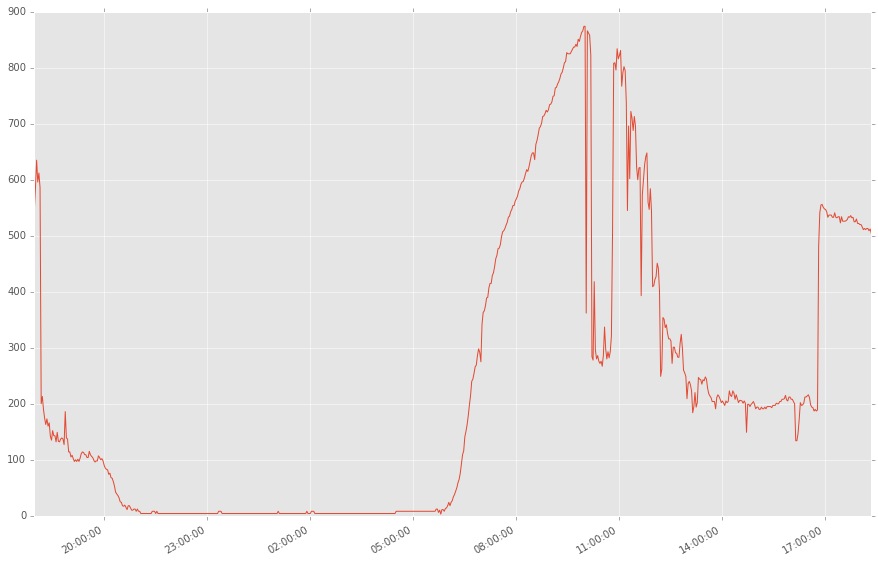

In [8]:
# graph the full raw series
raw_series_writer.result.plot(figsize=(15,10))

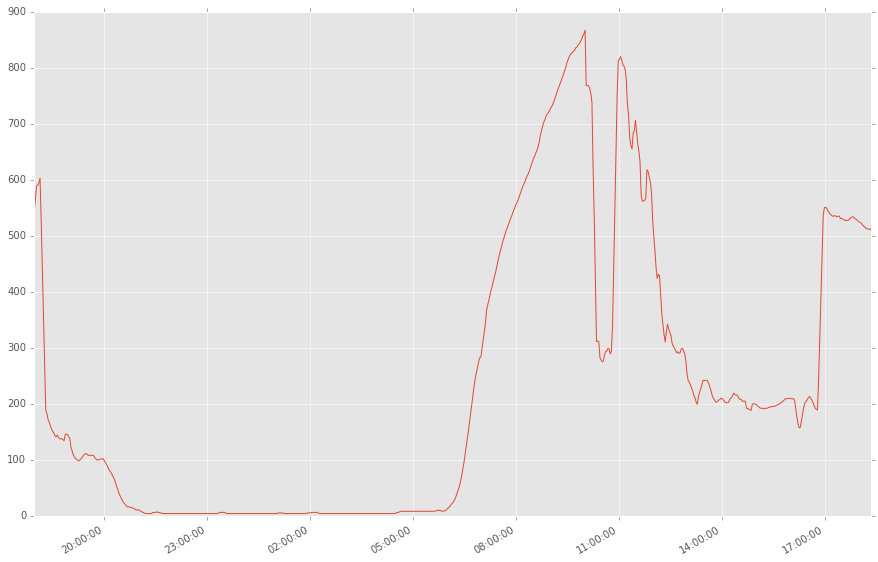

In [9]:
# graph the smoothed series
smoothed_series_writer.result.plot(figsize=(15,10))

In [10]:
# Now, lets try clustering the data

import numpy as np
from sklearn.cluster import KMeans
npa = np.array(smoothed_series_writer.result).reshape(-1,1)
kmeans = KMeans(4)
kmeans.fit(npa)
labels = kmeans.labels_
# print the raw clustered data
print(labels)

[0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 0 0 0 2 2 

In [11]:
# Now, we can convert it back to a Pandas series by using our original timestamp
# array with the clustered data.
clusters_against_time = pd.Series(kmeans.labels_, index=smoothed_series_writer.index)
# print the first few entries
print(clusters_against_time[:5])

2016-05-03 17:58:34.728774+02:00    0
2016-05-03 18:00:34.828998+02:00    0
2016-05-03 18:02:34.929086+02:00    0
2016-05-03 18:04:35.029235+02:00    0
2016-05-03 18:06:35.088212+02:00    0
dtype: int32


(0, 3.5)

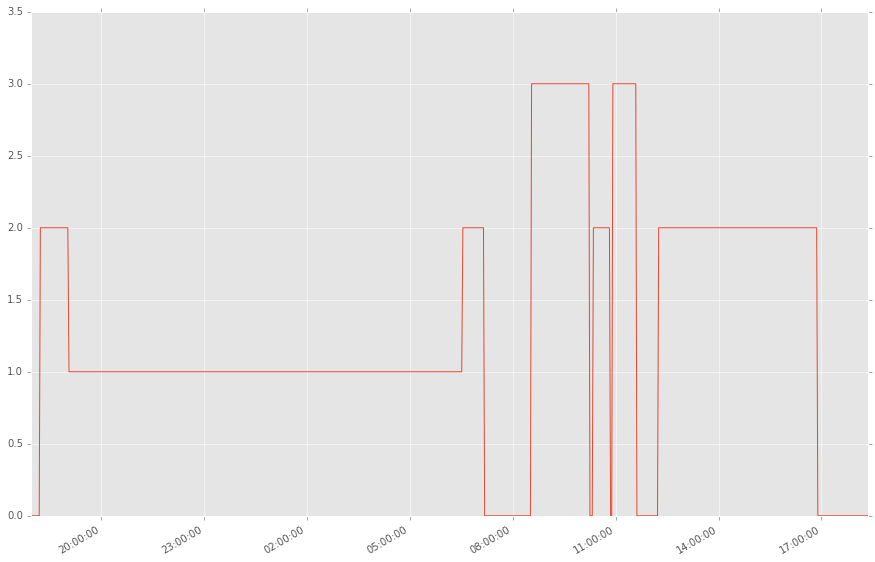

In [14]:
# Graph it!
clusters_against_time.plot(figsize=(15,10))
import pylab
pylab.ylim([0,3.5]) # force the graph top a little higher so that we can see the 3.0 lines